<a href="https://colab.research.google.com/github/erbisti/Collab/blob/main/Perceptron_4_entradas_notas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perceptron com 4 entradas - 3 valores numéricos + 1 dado categórico.**

# Vamos executar um código que entrega ao neurônio artificial (perceptron) 3 notas brutas (a nota de entrada, antes de quaisquer alterações) e o sexo do aluno, e analisa a situação que é dada ao final do fechamento das turmas.
# Este exemplo é apenas genérico, não tem nenhuma correlação com dados reais, serve apenas para entender a capacidade dos neuronios de conseguir capturar caracteristicas de conjunto de dados usando um exemplo que envolve dados numéricos e dados categóricos.

[Split] Treino: M=400  F=400 | Teste: M=100  F=100
[TREINO] Acurácia=0.996  Precisão(Aprovado)=1.000
[TESTE ] Acurácia=1.000  Precisão(Aprovado)=1.000
[TESTE ] Matriz de confusão (linhas=Real, colunas=Previsto) [Reprovado, Aprovado]:
[[ 95   0]
 [  0 105]]

[TESTE - Masculino]  Acurácia=1.000  Precisão(Aprovado)=1.000
[[48  0]
 [ 0 52]]

[TESTE - Feminino ]  Acurácia=1.000  Precisão(Aprovado)=1.000
[[47  0]
 [ 0 53]]


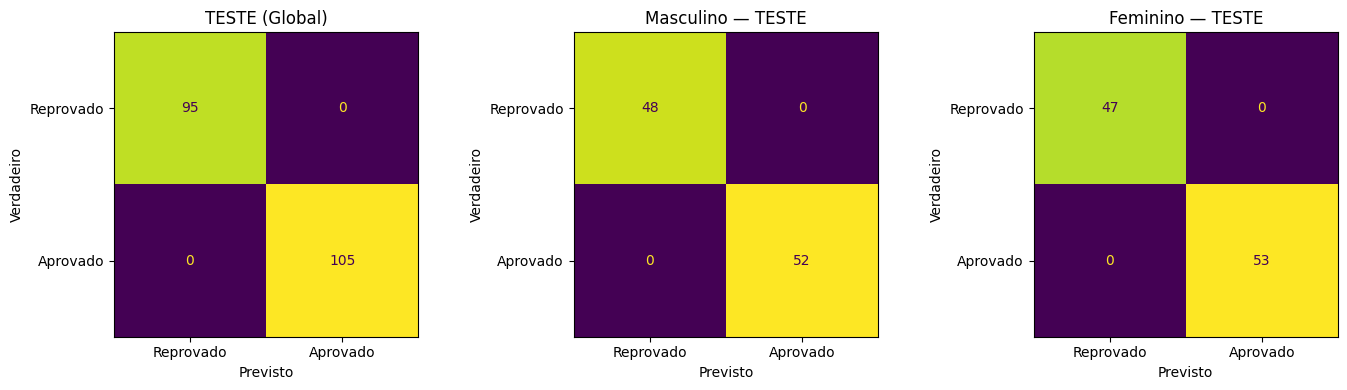

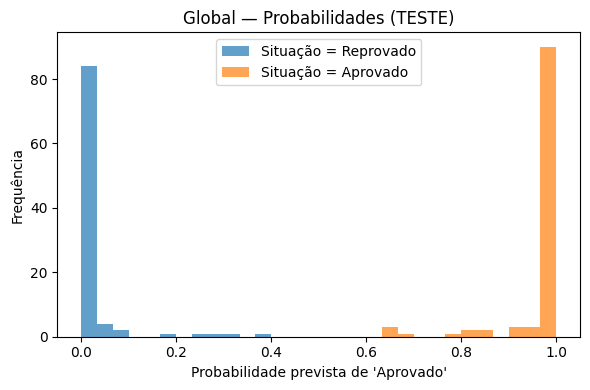

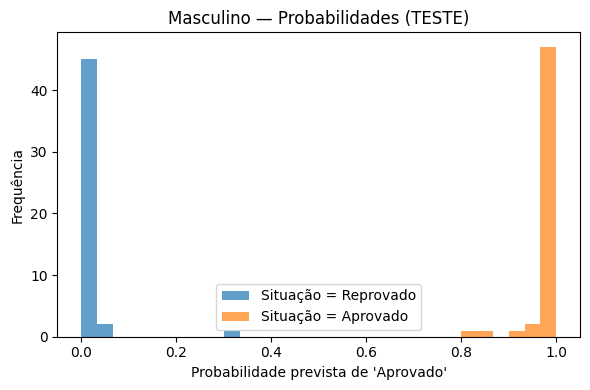

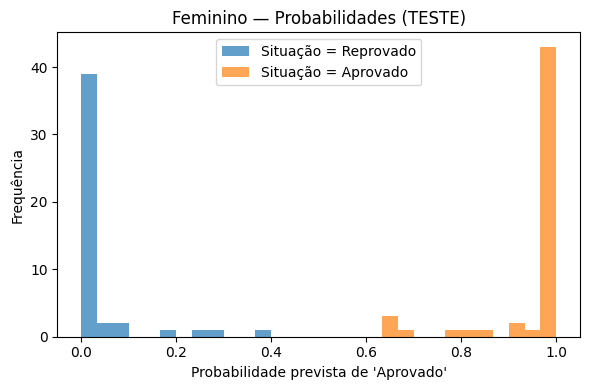


=== Teste com média 4.9 ===
Homem  (esperado=0) -> prob_aprovado=0.2522, classe_predita=0
Mulher (esperado=1) -> prob_aprovado=0.7436, classe_predita=1


In [ ]:
# Dataset: n1, n2, n3, sexo (0=masc, 1=fem)
# Rótulo: aprovado=1 se média>5.0 (masc) OU média>4.8 (fem); caso contrário 0
# Simplificações pedidas:
#  - Ordem aleatória antes do split
#  - Split ESTRATIFICADO por SEXO (fica simétrico: 50/50 no teste)
#  - Métricas: apenas acurácia e precisão (global e por sexo)
#  - ColumnTransformer: escala só n1..n3; 'sexo' passa sem transformação
#  - Teste de sensibilidade: média 4.9 (homem vs mulher)

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------------------------
# 1) Geração dos dados
# ---------------------------
np.random.seed(7)
tf.random.set_seed(7)

N_M = 500  # homens (sexo=0)
N_F = 500  # mulheres (sexo=1)

def gera_notas(n):
    n1 = np.random.uniform(0, 10, size=n)
    n2 = np.random.uniform(0, 10, size=n)
    n3 = np.random.uniform(0, 10, size=n)
    return n1, n2, n3

# Homens
n1_m, n2_m, n3_m = gera_notas(N_M)
sexo_m = np.zeros(N_M, dtype=np.float32)  # 0 = masc
media_m = (n1_m + n2_m + n3_m) / 3.0
y_m = (media_m > 5.0).astype(np.float32)

# Mulheres
n1_f, n2_f, n3_f = gera_notas(N_F)
sexo_f = np.ones(N_F, dtype=np.float32)   # 1 = fem
media_f = (n1_f + n2_f + n3_f) / 3.0
y_f = (media_f > 4.8).astype(np.float32)

# Matriz de features e vetor de rótulos (empilha e embaralha ANTES do split)
X = np.column_stack([
    np.concatenate([n1_m, n1_f]),
    np.concatenate([n2_m, n2_f]),
    np.concatenate([n3_m, n3_f]),
    np.concatenate([sexo_m, sexo_f])
]).astype(np.float32)
y = np.concatenate([y_m, y_f]).astype(np.float32)

idx = np.random.permutation(len(y))
X, y = X[idx], y[idx]

# ---------------------------
# 2) Split treino/teste ESTRATIFICADO POR SEXO + ColumnTransformer
#    (usa test_size=0.20 para ficar exatamente 50/50 por sexo no teste: 50 + 50)
# ---------------------------
sexo_full = X[:, 3].astype(int)  # para estratificar por sexo
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=7, stratify=sexo_full
)

ct = ColumnTransformer(
    transformers=[('num', StandardScaler(), [0, 1, 2])],
    remainder='passthrough'  # mantém 'sexo' na última coluna, como 0/1
)
X_tr = ct.fit_transform(X_tr)  # fit NO TREINO
X_te = ct.transform(X_te)      # transform NO TESTE

# Checagem de simetria (contagem por sexo em treino/teste)
n_tr_m = int(np.sum(X_tr[:, 3] == 0.0))
n_tr_f = int(np.sum(X_tr[:, 3] == 1.0))
n_te_m = int(np.sum(X_te[:, 3] == 0.0))
n_te_f = int(np.sum(X_te[:, 3] == 1.0))
print(f"[Split] Treino: M={n_tr_m}  F={n_tr_f} | Teste: M={n_te_m}  F={n_te_f}")

# ---------------------------
# 3) Modelo (perceptron: 1 neurônio, sigmoide)
# ---------------------------
model = keras.Sequential([
    keras.layers.Input(shape=(4,)),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.02),
              loss="binary_crossentropy",
              metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
_ = model.fit(X_tr, y_tr,
              epochs=300, batch_size=32,
              validation_split=0.2,
              callbacks=[es], verbose=0)

# ---------------------------
# 4) Avaliação: apenas ACURÁCIA e PRECISÃO
#    (Precisão da classe positiva = 'Aprovado' = 1)
# ---------------------------
def acc_prec(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / cm.sum() if cm.sum() > 0 else 0.0
    precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    return accuracy, precision_pos, cm

p_tr = model.predict(X_tr, verbose=0).flatten()
p_te = model.predict(X_te, verbose=0).flatten()
yhat_tr = (p_tr >= 0.5).astype(int)
yhat_te = (p_te >= 0.5).astype(int)

acc_tr, prec_tr, cm_tr = acc_prec(y_tr, yhat_tr)
acc_te, prec_te, cm_te = acc_prec(y_te, yhat_te)

print(f"[TREINO] Acurácia={acc_tr:.3f}  Precisão(Aprovado)={prec_tr:.3f}")
print(f"[TESTE ] Acurácia={acc_te:.3f}  Precisão(Aprovado)={prec_te:.3f}")
print("[TESTE ] Matriz de confusão (linhas=Real, colunas=Previsto) [Reprovado, Aprovado]:")
print(cm_te)

# ---------------------------
# 5) Métricas por sexo (TESTE): acurácia e precisão
# ---------------------------
mask_m = (X_te[:, 3] == 0.0)  # masculino
mask_f = (X_te[:, 3] == 1.0)  # feminino

acc_te_m, prec_te_m, cm_m = acc_prec(y_te[mask_m], yhat_te[mask_m])
acc_te_f, prec_te_f, cm_f = acc_prec(y_te[mask_f], yhat_te[mask_f])

print(f"\n[TESTE - Masculino]  Acurácia={acc_te_m:.3f}  Precisão(Aprovado)={prec_te_m:.3f}")
print(cm_m)
print(f"\n[TESTE - Feminino ]  Acurácia={acc_te_f:.3f}  Precisão(Aprovado)={prec_te_f:.3f}")
print(cm_f)

# ---------------------------
# 6) Matrizes de confusão (plots)
# ---------------------------
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

ConfusionMatrixDisplay(cm_te, display_labels=["Reprovado","Aprovado"]).plot(
    values_format="d", ax=axs[0], colorbar=False)
axs[0].set_title("TESTE (Global)")
axs[0].set_xlabel("Previsto"); axs[0].set_ylabel("Verdadeiro")

ConfusionMatrixDisplay(cm_m, display_labels=["Reprovado","Aprovado"]).plot(
    values_format="d", ax=axs[1], colorbar=False)
axs[1].set_title("Masculino — TESTE")
axs[1].set_xlabel("Previsto"); axs[1].set_ylabel("Verdadeiro")

ConfusionMatrixDisplay(cm_f, display_labels=["Reprovado","Aprovado"]).plot(
    values_format="d", ax=axs[2], colorbar=False)
axs[2].set_title("Feminino — TESTE")
axs[2].set_xlabel("Previsto"); axs[2].set_ylabel("Verdadeiro")

plt.tight_layout()
plt.show()

# ---------------------------
# 7) Histogramas das probabilidades (TESTE) — legendas claras
# ---------------------------
bins = np.linspace(0, 1, 31)

def plot_hist(prob, y_true, mask, titulo):
    plt.figure(figsize=(6,4))
    plt.hist(prob[(y_true == 0) & mask], bins=bins, alpha=0.7, label="Situação = Reprovado")
    plt.hist(prob[(y_true == 1) & mask], bins=bins, alpha=0.7, label="Situação = Aprovado")
    plt.xlabel("Probabilidade prevista de 'Aprovado'")
    plt.ylabel("Frequência")
    plt.title(titulo)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hist(p_te, y_te, np.ones_like(y_te, dtype=bool), "Global — Probabilidades (TESTE)")
plot_hist(p_te, y_te, mask_m, "Masculino — Probabilidades (TESTE)")
plot_hist(p_te, y_te, mask_f, "Feminino — Probabilidades (TESTE)")

# ---------------------------
# 8) Teste de sensibilidade: média 4.9 (homem vs mulher)
# ---------------------------
def predict_one(n1, n2, n3, sexo):
    x = np.array([[n1, n2, n3, sexo]], dtype=np.float32)
    x_ct = ct.transform(x)                         # mesma transformação do treino
    p = float(model.predict(x_ct, verbose=0).flatten()[0])
    yhat = int(p >= 0.5)
    return p, yhat

p_h, y_h = predict_one(4.9, 4.9, 4.9, sexo=0)  # homem (esperado=0)
p_m, y_m = predict_one(4.9, 4.9, 4.9, sexo=1)  # mulher (esperado=1)

print("\n=== Teste com média 4.9 ===")
print(f"Homem  (esperado=0) -> prob_aprovado={p_h:.4f}, classe_predita={y_h}")
print(f"Mulher (esperado=1) -> prob_aprovado={p_m:.4f}, classe_predita={y_m}")
